In [1]:
# %%
import copy
import gc
import json
import os
from pathlib import Path
import shutil
import sys
import time
import traceback
from typing import List, Tuple, Dict, Union, Optional
import warnings
import pandas as pd
# from . import asyn
import pickle
import torch
from anndata import AnnData
import scanpy as sc
# import scvi
import seaborn as sns
import numpy as np
import wandb
from scipy.sparse import issparse
import matplotlib.pyplot as plt
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from torchtext.vocab import Vocab
from torchtext._torchtext import (
    Vocab as VocabPybind,
)
from sklearn.metrics import confusion_matrix

sys.path.insert(0, "../")
import scgpt as scg
from scgpt.model.model_main import TransformerModel, AdversarialDiscriminator
from scgpt.tokenizer import tokenize_and_pad_batch, random_mask_value
from scgpt.loss import (
    masked_mse_loss,
    masked_relative_error,
    criterion_neg_log_bernoulli,
)
from scgpt.tokenizer.gene_tokenizer import GeneVocab
from scgpt.preprocess import Preprocessor
from scgpt import SubsetsBatchSampler
from scgpt.utils import set_seed, category_str2int, eval_scib_metrics
from torch.utils.data.sampler import RandomSampler, SequentialSampler


sc.set_figure_params(figsize=(6, 6))
os.environ["KMP_WARNINGS"] = "off"
warnings.filterwarnings('ignore')

/share/org/BGI/bgi_clicx/miniconda3/envs/scgpt/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/share/org/BGI/bgi_clicx/miniconda3/envs/scgpt/lib/python3.11/site-packages/einops/_torch_specific.py:109: ImportWarning: allow_ops_in_compiled_graph failed to import torch: ensure pytorch >=2.0
  warnings.warn("allow_ops_in_compiled_graph failed to import torch: ensure pytorch >=2.0", ImportWarning)


In [2]:
hyperparameter_defaults = dict(
    seed=0,

    model_file = '/share/org/BGI/bgi_clicx/Huawei/scGPT-QP/tutorials/save/QP_SRP250946-Nov09-21-33/model.pt',
    model_param_file = '/share/org/BGI/bgi_clicx/Huawei/scGPT-QP/tutorials/save/QP_SRP250946-Nov09-21-33/args.json',
    vocab_file = '/share/org/BGI/bgi_clicx/Huawei/scGPT-QP/tutorials/save/QP_SRP250946-Nov09-21-33/vocab.json',
    input_file = '/share/org/BGI/bgi_clicx/Huawei/scGPT-QP/tutorials/save/QP_SRP250946-Nov09-21-33/adata_test_raw.h5ad',

    mask_ratio=0.0,
    epochs=10,
    n_bins=51,
    MVC=False, # Masked value prediction for cell embedding
    ecs_thres=0.0, # Elastic cell similarity objective, 0.0 to 1.0, 0.0 to disable
    dab_weight=0.0,
    lr=1e-4,
    batch_size=128,
    layer_size=256,
    nlayers=6,  # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
    nhead=4,  # number of heads in nn.MultiheadAttention
    dropout=0.2,  # dropout probability
    schedule_ratio=0.9,  # ratio of epochs for learning rate schedule
    save_eval_interval=5,
    fast_transformer=True,
    pre_norm=False,
    amp=True,  # Automatic Mixed Precision
    include_zero_gene = False,
    freeze = False, #freeze
    DSBN = False,  # Domain-spec batchnorm
)

In [3]:
run = wandb.init(
    config=hyperparameter_defaults,
    project="scGPT",
    reinit=True,
    settings=wandb.Settings(start_method="fork"),
    mode="disabled"
)
config = wandb.config
print(config)

set_seed(config.seed)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


{'seed': 0, 'model_file': '/share/org/BGI/bgi_clicx/Huawei/scGPT-QP/tutorials/save/QP_SRP250946-Nov09-21-33/model.pt', 'model_param_file': '/share/org/BGI/bgi_clicx/Huawei/scGPT-QP/tutorials/save/QP_SRP250946-Nov09-21-33/args.json', 'vocab_file': '/share/org/BGI/bgi_clicx/Huawei/scGPT-QP/tutorials/save/QP_SRP250946-Nov09-21-33/vocab.json', 'input_file': '/share/org/BGI/bgi_clicx/Huawei/scGPT-QP/tutorials/save/QP_SRP250946-Nov09-21-33/adata_test_raw.h5ad', 'mask_ratio': 0.0, 'epochs': 10, 'n_bins': 51, 'MVC': False, 'ecs_thres': 0.0, 'dab_weight': 0.0, 'lr': 0.0001, 'batch_size': 128, 'layer_size': 256, 'nlayers': 6, 'nhead': 4, 'dropout': 0.2, 'schedule_ratio': 0.9, 'save_eval_interval': 5, 'fast_transformer': True, 'pre_norm': False, 'amp': True, 'include_zero_gene': False, 'freeze': False, 'DSBN': False}


In [4]:
# settings for input and preprocessing
pad_token = "<pad>"
special_tokens = [pad_token, "<cls>", "<eoc>"]
mask_ratio = config.mask_ratio
mask_value = "auto"  # for masked values, now it should always be auto

include_zero_gene = config.include_zero_gene  # if True, include zero genes among hvgs in the training
max_seq_len = 3001
n_bins = config.n_bins

# input/output representation
input_style = "binned"  # "normed_raw", "log1p", or "binned"
output_style = "binned"  # "normed_raw", "log1p", or "binned"

# settings for training
MLM = False  # whether to use masked language modeling, currently it is always on.
CLS = True  # celltype classification objective
ADV = False  # Adversarial training for batch correction
CCE = False  # Contrastive cell embedding objective
MVC = config.MVC  # Masked value prediction for cell embedding
ECS = config.ecs_thres > 0  # Elastic cell similarity objective
DAB = False  # Domain adaptation by reverse backpropagation, set to 2 for separate optimizer
INPUT_BATCH_LABELS = False  # TODO: have these help MLM and MVC, while not to classifier
input_emb_style = "continuous"  # "category" or "continuous" or "scaling"
cell_emb_style = "cls"  # "avg-pool" or "w-pool" or "cls"
adv_E_delay_epochs = 0  # delay adversarial training on encoder for a few epochs
adv_D_delay_epochs = 0
mvc_decoder_style = "inner product"
ecs_threshold = config.ecs_thres
dab_weight = config.dab_weight

explicit_zero_prob = MLM and include_zero_gene  # whether explicit bernoulli for zeros
do_sample_in_train = False and explicit_zero_prob  # sample the bernoulli in training

per_seq_batch_sample = False

# settings for optimizer
lr = config.lr  # TODO: test learning rate ratio between two tasks
lr_ADV = 1e-3  # learning rate for discriminator, used when ADV is True
batch_size = config.batch_size
eval_batch_size = config.batch_size
epochs = config.epochs
schedule_interval = 1

# settings for the model
fast_transformer = config.fast_transformer
fast_transformer_backend = "flash"  # "linear" or "flash"
embsize = config.layer_size  # embedding dimension
d_hid = config.layer_size  # dimension of the feedforward network in TransformerEncoder
nlayers = config.nlayers  # number of TransformerEncoderLayer in TransformerEncoder
nhead = config.nhead  # number of heads in nn.MultiheadAttention
dropout = config.dropout  # dropout probability

# logging
log_interval = 100  # iterations
save_eval_interval = config.save_eval_interval  # epochs
do_eval_scib_metrics = True


#sc--->0   st--->1
mod_type = 0


In [5]:
# %% validate settings
assert input_style in ["normed_raw", "log1p", "binned"]
assert output_style in ["normed_raw", "log1p", "binned"]
assert input_emb_style in ["category", "continuous", "scaling"]
if input_style == "binned":
    if input_emb_style == "scaling":
        raise ValueError("input_emb_style `scaling` is not supported for binned input.")
elif input_style == "log1p" or input_style == "normed_raw":
    if input_emb_style == "category":
        raise ValueError(
            "input_emb_style `category` is not supported for log1p or normed_raw input."
        )

if input_emb_style == "category":
    mask_value = n_bins + 1
    pad_value = n_bins  # for padding gene expr values
    n_input_bins = n_bins + 2
else:
    mask_value = -1
    pad_value = -2
    n_input_bins = n_bins

if ADV and DAB:
    raise ValueError("ADV and DAB cannot be both True.")
DAB_separate_optim = True if DAB > 1 else False

In [6]:

adata = sc.read(config.input_file)

adata.obs["celltype"] = adata.obs["Celltype"].astype("category")
adata.obs["batch_id"]  = adata.obs["str_batch"] = "0"
# adata.obs['mod_type'] = mod_type

data_is_raw = True
filter_gene_by_counts = False

# make the batch category column
batch_id_labels = adata.obs["str_batch"].astype("category").cat.codes.values
adata.obs["batch_id"] = batch_id_labels
celltype_id_labels = adata.obs["celltype"].astype("category").cat.codes.values
celltypes = adata.obs["celltype"].unique()
num_types = len(np.unique(celltype_id_labels))
id2type = dict(enumerate(adata.obs["celltype"].astype("category").cat.categories))
adata.obs["celltype_id"] = celltype_id_labels
adata.var["gene_name"] = adata.var.index.tolist()



In [7]:
if config.model_file is not None:

    model_file = config.model_file
    model_config_file = config.model_param_file
    vocab_file = config.vocab_file

    vocab = GeneVocab.from_file(vocab_file)

    for s in special_tokens:
        if s not in vocab:
            vocab.append_token(s)

    adata.var["id_in_vocab"] = [
        1 if gene in vocab else -1 for gene in adata.var["gene_name"]
    ]
    gene_ids_in_vocab = np.array(adata.var["id_in_vocab"])
    # logger.info(
    #     f"match {np.sum(gene_ids_in_vocab >= 0)}/{len(gene_ids_in_vocab)} genes "
    #     f"in vocabulary of size {len(vocab)}."
    # )
    adata = adata[:, adata.var["id_in_vocab"] >= 0]

    # model
    with open(model_config_file, "r") as f:
        model_configs = json.load(f)
    # logger.info(
    #     f"Resume model from {model_file}, the model args will override the "
    #     f"config {model_config_file}."
    # )
    embsize = model_configs["embsize"]
    nhead = model_configs["nheads"]
    d_hid = model_configs["d_hid"]
    nlayers = model_configs["nlayers"]
    n_layers_cls = model_configs["n_layers_cls"]

In [8]:
# set up the preprocessor, use the args to config the workflow
preprocessor = Preprocessor(
    use_key="X",  # the key in adata.layers to use as raw data
    filter_gene_by_counts=filter_gene_by_counts,  # step 1
    filter_cell_by_counts=False,  # step 2
    normalize_total=1e4,  # 3. whether to normalize the raw data and to what sum
    result_normed_key="X_normed",  # the key in adata.layers to store the normalized data
    log1p=data_is_raw,  # 4. whether to log1p the normalized data
    result_log1p_key="X_log1p",
    subset_hvg=False,  # 5. whether to subset the raw data to highly variable genes
    hvg_flavor="seurat_v3" if data_is_raw else "cell_ranger",
    binning=n_bins,  # 6. whether to bin the raw data and to what number of bins
    result_binned_key="X_binned",  # the key in adata.layers to store the binned data
)

preprocessor(adata, batch_key=None)


scGPT - INFO - Filtering cells by counts ...
scGPT - INFO - Normalizing total counts ...
scGPT - INFO - Log1p transforming ...
scGPT - INFO - Binning data ...


In [9]:
class SeqDataset(Dataset):
    def __init__(self, data: Dict[str, torch.Tensor]):
        self.data = data

    def __len__(self):
        return self.data["gene_ids"].shape[0]

    def __getitem__(self, idx):
        return {k: v[idx] for k, v in self.data.items()}


In [10]:
input_layer_key = {  # the values of this map coorespond to the keys in preprocessing
    "normed_raw": "X_normed",
    "log1p": "X_med",
    "binned": "X_binned",
}[input_style]


all_counts = (
    adata.layers[input_layer_key].A
    if issparse(adata.layers[input_layer_key])
    else adata.layers[input_layer_key]
)
genes = adata.var["gene_name"].tolist()


vocab.set_default_index(vocab["<pad>"])
gene_ids = np.array(vocab(genes), dtype=int)

celltypes_labels = adata.obs["celltype_id"].tolist()  # make sure count from 0
celltypes_labels = np.array(celltypes_labels)

batch_ids = adata.obs["batch_id"].tolist()
batch_ids = np.array(batch_ids)

# mod_types = adata.obs['mod_type'].tolist()
# mod_types = np.array(mod_types)

tokenized_adata = tokenize_and_pad_batch(
    all_counts,
    gene_ids,
    max_len=max_seq_len,
    vocab=vocab,
    pad_token=pad_token,
    pad_value=pad_value,
    append_cls=True,  # append <cls> token at the beginning
    include_zero_gene=include_zero_gene,
)

input_values_test = random_mask_value(
    tokenized_adata["values"],
    mask_ratio=mask_ratio,
    mask_value=mask_value,
    pad_value=pad_value,
)


data_pt = {
    "gene_ids": tokenized_adata["genes"],
    "values": input_values_test,
    "target_values": tokenized_adata["values"],
    "batch_labels": torch.from_numpy(batch_ids).long(),
    # "mod_labels": torch.from_numpy(mod_types).long(),
    "celltype_labels": torch.from_numpy(celltypes_labels).long(),
}

dataset=SeqDataset(data_pt)


sampler = SequentialSampler(dataset)

data_loader = DataLoader(
    dataset=dataset,
    batch_size=eval_batch_size,
    shuffle=False,
    drop_last=False,
    # num_workers=min(len(os.sched_getaffinity(0)), eval_batch_size // 2),
    num_workers = 4,
    sampler=sampler,
    # pin_memory=True,
)

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

ntokens = len(vocab)  # size of vocabulary
model = TransformerModel(
    ntokens,
    embsize,
    nhead,
    d_hid,
    nlayers,
    nlayers_cls=3,
    n_cls=num_types if CLS else 1,
    vocab=vocab,
    dropout=dropout,
    pad_token=pad_token,
    pad_value=pad_value,
    do_mvc=MVC,
    do_dab=DAB,
    use_batch_labels=INPUT_BATCH_LABELS,
    # num_batch_labels=num_batch_types,
    domain_spec_batchnorm=config.DSBN,
    input_emb_style=input_emb_style,
    n_input_bins=n_input_bins,
    cell_emb_style=cell_emb_style,
    mvc_decoder_style=mvc_decoder_style,
    ecs_threshold=ecs_threshold,
    explicit_zero_prob=explicit_zero_prob,
    use_fast_transformer=fast_transformer,
    fast_transformer_backend=fast_transformer_backend,
    pre_norm=config.pre_norm,
)
if config.model_file is not None:
    try:
        model.load_state_dict(torch.load(model_file, map_location=device))
    except:
        # only load params that are in the model and match the size
        model_dict = model.state_dict()
        pretrained_dict = torch.load(model_file, map_location=device)
        pretrained_dict = {
            k: v
            for k, v in pretrained_dict.items()
            if k in model_dict and v.shape == model_dict[k].shape
        }
        for k, v in pretrained_dict.items():
            print(f"Loading params {k} with shape {v.shape}")
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict)

model.to(device)
model.eval()

TransformerModel(
  (encoder): GeneEncoder(
    (embedding): Embedding(40158, 256, padding_idx=40155)
    (enc_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  )
  (value_encoder): ContinuousValueEncoder(
    (dropout): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=1, out_features=256, bias=True)
    (activation): ReLU()
    (linear2): Linear(in_features=256, out_features=256, bias=True)
    (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x FlashTransformerEncoderLayer(
        (self_attn): FlashMHA(
          (Wqkv): Linear(in_features=256, out_features=768, bias=True)
          (inner_attn): FlashAttention()
          (out_proj): Linear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=256, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=25

In [12]:
from tqdm import tqdm

cell_embeddings = np.zeros((adata.shape[0], embsize), dtype=np.float32)
# celltypes = []
with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):
    count = 0
    for batch_data in tqdm(data_loader, desc='Cell embedding'):

        input_gene_ids = batch_data["gene_ids"].to(device)
        input_values = batch_data["values"].to(device)
        target_values = batch_data["target_values"].to(device)
        batch_labels = batch_data["batch_labels"].to(device)
        # mod_labels = batch_data["mod_labels"].to(device)
        celltype_labels = batch_data["celltype_labels"].to(device)


        src_key_padding_mask = input_gene_ids.eq(vocab[pad_token])

        # output = self.model(
        #     input_gene_ids,
        #     input_values,
        #     src_key_padding_mask=src_key_padding_mask,
        #     batch_labels=None,
        # )

        output = model(
            input_gene_ids,
            input_values,
            src_key_padding_mask=src_key_padding_mask,
            # mod_types=mod_labels,
            # batch_labels=batch_labels if INPUT_BATCH_LABELS or config.DSBN else None,
            # CLS=CLS,  # evaluation does not need CLS or CCE
            # CCE=False,
            # MVC=False,
            # ECS=False,
            # do_sample=do_sample_in_train,
            #generative_training = False,
        )
        embeddings = output['cell_emb']  # get the <cls> position embedding
        embeddings = embeddings.cpu().numpy()
        cell_embeddings[count: count + len(embeddings)] = embeddings
        count += len(embeddings)


Cell embedding: 100%|████████████████████████| 124/124 [00:16<00:00,  7.75it/s]


In [13]:
print('embedding shape:', cell_embeddings.shape)
scg_cell_emb = pd.DataFrame(cell_embeddings, index=adata.obs_names)

adata.obsm['X_scGPT'] = scg_cell_emb.values


embedding shape: (15870, 256)


In [14]:
adata

AnnData object with n_obs × n_vars = 15870 × 25872
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Orig.ident', 'Percent.mt', 'Seurat_clusters', 'Celltype', 'Genotype', 'celltype', 'batch_id', 'str_batch', 'predictions', 'celltype_id', 'n_counts'
    var: 'name', 'gene_name', 'id_in_vocab'
    uns: 'log1p'
    obsm: 'bin_edges', 'X_scGPT'
    layers: 'X_normed', 'X_log1p', 'X_binned'

In [15]:
sc.pp.neighbors(adata, use_rep='X_scGPT')
sc.tl.umap(adata)

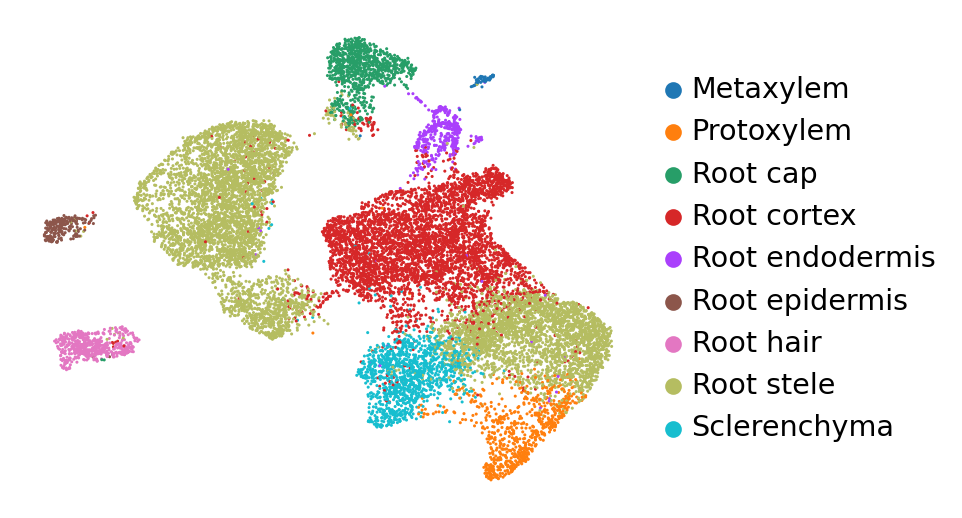

In [16]:
plt.rcParams['figure.figsize'] = (5, 4)
fig = sc.pl.umap(adata, color='Celltype',
                    # legend_loc='none',
                    frameon=False,
                    # palette=ct2color_dict, 
                    title='', return_fig=True)
plt.show()
plt.close()

In [17]:
adata.layers.clear()
adata.uns.clear()
adata.obsp.clear()
adata.write('/share/org/BGI/bgi_clicx/scGPT-QP/tutorials/save/QP_SRP250946-Nov09-21-33/adata_test-X_scGPT.h5ad')

In [18]:
adata

AnnData object with n_obs × n_vars = 15870 × 25872
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Orig.ident', 'Percent.mt', 'Seurat_clusters', 'Celltype', 'Genotype', 'celltype', 'batch_id', 'str_batch', 'predictions', 'celltype_id', 'n_counts'
    var: 'name', 'gene_name', 'id_in_vocab'
    uns: 'log1p', 'neighbors', 'umap', 'Celltype_colors'
    obsm: 'bin_edges', 'X_scGPT', 'X_umap'
    layers: 'X_normed', 'X_log1p', 'X_binned'
    obsp: 'distances', 'connectivities'